# COURSERA CAPSTONE FINAL PROJECT, WEEKS 4 & 5

## Import required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Import and explore Toronto postalcode areas

In [2]:
# import data frame
df=pd.read_csv('Toronto_neighborhoods_WithGeospacial.csv')
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [3]:
print('The dataframe has {} boroughs and {} Neighborhood.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 Neighborhood.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with Neighborhoods superimposed on top.

In [5]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'],\
                                           df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Define Foursquare Credentials and Version

In [6]:
# Note that these credentials are saved in Credentials.csv which is not shared on github
Cred_data=pd.read_csv('Credentials.csv')
CLIENT_ID='5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L'#Cred_data['CLIENT_ID'][0]
CLIENT_SECRET='TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43'#Cred_data['CLIENT_SECRET'][0]
VERSION=Cred_data['VERSION'][0]
LIMIT=Cred_data['LIMIT'][0]

**Fetch Foursquare Venue Category Hierarchy**

In [18]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [8]:
with open('category_results.json', 'w') as f:
    json.dump(category_results, f)

In [9]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [10]:
category_list = category_results['response']['categories']
len(category_list)

10

In [11]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


**_Outdoors & Recreation_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Outdoors & Recreation_ & It's Sub-Categories.

In [19]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [20]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06377d81259')

In [21]:
category_dict

{'4d4b7105d754a06377d81259': 'Outdoors & Recreation',
 '4f4528bc4b90abdf24c9de85': 'Athletics & Sports',
 '52e81612bcbc57f1066b7a2b': 'Badminton Court',
 '4bf58dd8d48988d1e8941735': 'Baseball Field',
 '4bf58dd8d48988d1e1941735': 'Basketball Court',
 '52e81612bcbc57f1066b7a2f': 'Bowling Green',
 '56aa371be4b08b9a8d57351a': 'Curling Ice',
 '4bf58dd8d48988d1e6941735': 'Golf Course',
 '58daa1558bbb0b01f18ec1b0': 'Golf Driving Range',
 '4bf58dd8d48988d175941735': 'Gym / Fitness Center',
 '52f2ab2ebcbc57f1066b8b47': 'Boxing Gym',
 '503289d391d4c4b30a586d6a': 'Climbing Gym',
 '52f2ab2ebcbc57f1066b8b49': 'Cycle Studio',
 '4bf58dd8d48988d105941735': 'Gym Pool',
 '52f2ab2ebcbc57f1066b8b48': 'Gymnastics Gym',
 '4bf58dd8d48988d176941735': 'Gym',
 '4bf58dd8d48988d101941735': 'Martial Arts Dojo',
 '58daa1558bbb0b01f18ec203': 'Outdoor Gym',
 '5744ccdfe4b0c0459246b4b2': 'Pilates Studio',
 '4bf58dd8d48988d106941735': 'Track',
 '590a0744340a5803fd8508c3': 'Weight Loss Center',
 '4bf58dd8d48988d102941735

Now, we have all the categories in _Outdooes and recreation_ with their id's.

#### Explore the first Neighborhood to understand the results of GET Request

Get the Neighborhood's name.

In [22]:
df.loc[0, 'Neighborhood']

'Parkwoods'

Get the Neighborhood's latitude and longitude values.

In [16]:
neighborhood_latitude = df.loc[0, 'Latitude'] # Neighborhood area latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # Neighborhood area longitude value

neighborhood_name = df.loc[0, 'Postalcode'] # postalcode name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of M3A are 43.7532586, -79.3296565.


#### Now, let's get the _Sport & Recreation_ that is in ... within a radius of 500 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [23]:
LIMIT = 10 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06377d81259' # category ID for "Sport & Recreation"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L&client_secret=TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43&v=20180604&ll=43.7532586,-79.3296565&radius=500&categoryId=4d4b7105d754a06377d81259&limit=10'

Send the GET request and examine the resutls

In [24]:
results = requests.get(url).json()

In [25]:
results['response']['venues'][0]

{'id': '4e8d9dcdd5fbbbb6b3003c7b',
 'name': 'Brookbanks Park',
 'location': {'address': 'Toronto',
  'lat': 43.751976046055574,
  'lng': -79.33214044722958,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958}],
  'distance': 245,
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
 'categories': [{'id': '4bf58dd8d48988d163941735',
   'name': 'Park',
   'pluralName': 'Parks',
   'shortName': 'Park',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1589327663',
 'hasPerk': False}

The category name of the venue **'Brookbanks Park'** is **'Parks'**.

As, our aim is to segment the neighborhoods of Toronto with respect to the _Sport & Recreation_ in its vicinity. We need to proceed further to fetch this data from all the 103 neighborhoods' venues.

#### Let's create a function to repeat the following process to all the postalcode areas in Toronto:
* Loop through postalcodes
    * Create the API request URL with radius=500, LIMIT=100
    * Make the GET request
    * For each postalcode, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

The _categoryId_ parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from _category_\__dict_.

In [ ]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

The above process turns out to be redundant because if a top-level category is specified in the GET Request, all sub-categories will also match the query. But it is an interesting way to retrieve all the sub-categories ID with name.

In [26]:
def getNearbySport(names, latitudes, longitudes, radius=500, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06377d81259", # "Sport and Recreation" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

**Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.**

In [27]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('Toronto_sport_venues.pkl', 'rb') as f:
        Toronto_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues = getNearbySport(names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_sport_venues.pkl', 'wb') as f:
        pickle.dump(Toronto_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


## 3. Analysis & Machine Learning

#### Let's check the size of the resulting dataframe

In [28]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1479, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Eagle Bridge,43.750453,-79.332259,Bridge
2,Parkwoods,43.753259,-79.329656,GreenWin pool,43.756232,-79.333842,Pool
3,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


#### Let's find out how many unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 87 uniques categories.


Venue Category
Park                                        224
Gym                                         217
Gym / Fitness Center                        138
Other Great Outdoors                        100
Playground                                   78
Athletics & Sports                           74
Yoga Studio                                  70
Pool                                         65
Dog Run                                      43
Garden                                       39
Scenic Lookout                               35
Plaza                                        33
Skating Rink                                 28
Martial Arts Dojo                            27
Sculpture Garden                             27
Tennis Court                                 21
Field                                        17
Bridge                                       16
Gym Pool                                     15
Farm                                         15
Harbor / Marina          

In [30]:
# list all the categories
unique_categories = Toronto_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Park, Bridge, Pool, Hockey Arena, Gym / Fitness Center, Playground, Other Great Outdoors, Sculpture Garden, Dog Run, Distribution Center, Historic Site, Yoga Studio, Gym, Track, Surf Spot, Farm, Dive Spot, Forest, Beach, Skating Rink, Botanical Garden, Harbor / Marina, Boxing Gym, Athletics & Sports, Martial Arts Dojo, Garden, Gym Pool, Scenic Lookout, Baseball Field, Golf Driving Range, Tennis Court, Plaza, Skate Park, Monument / Landmark, Non-Profit, Roof Deck, Hotel Pool, Basketball Court, Field, Cemetery, Outdoors & Recreation, Curling Ice, Fountain, Trail, College Gym, Pilates Studio, Recreation Center, Public Bathroom, Arcade, Ski Area, Gymnastics Gym, Flower Shop, Stables, Golf Course, Community Center, Mountain, Residential Building (Apartment / Condo), Well, Lighthouse, Soccer Field, Lake, Apres Ski Bar, Aquarium, Boat or Ferry, Art Gallery, Pet Service, Tanning Salon, Campground, Climbing Gym, Stadium, Cycle Studio, Sports Club, General Entertainment, College Stadium, Swim Sc

In [31]:
len(unique_categories)

87

### Analyze Each neighborhood

In [32]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot.head()

,Apres Ski Bar,Aquarium,Arcade,Art Gallery,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bike Trail,Boat or Ferry,Botanical Garden,Bowling Alley,Boxing Gym,Bridge,Building,Campground,Cemetery,Climbing Gym,College Gym,College Stadium,Community Center,Curling Ice,Cycle Studio,Distribution Center,Dive Spot,Dog Run,Farm,Field,Flower Shop,Forest,Fountain,Funeral Home,Garden,General Entertainment,Golf Course,Golf Driving Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Historic Site,Hockey Arena,Hot Spring,Hotel Pool,Indoor Play Area,Island,Lake,Lighthouse,Martial Arts Dojo,Medical Center,Monument / Landmark,Mountain,Non-Profit,Other Great Outdoors,Outdoors & Recreation,Park,Pet Service,Pilates Studio,Playground,Plaza,Pool,Public Bathroom,Recreation Center,Residential Building (Apartment / Condo),River,Roof Deck,Scenic Lookout,Sculpture Garden,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stables,Stadium,State / Provincial Park,Summer Camp,Surf Spot,Swim School,Tanning Salon,Tennis Court,Track,Trail,Tree,Well,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
Toronto_venues.shape

(1479, 7)

In [34]:
Toronto_onehot.shape

(1479, 87)

In [35]:
# add Postalcode column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 
Toronto_onehot.head()

,Apres Ski Bar,Aquarium,Arcade,Art Gallery,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bike Trail,Boat or Ferry,Botanical Garden,Bowling Alley,Boxing Gym,Bridge,Building,Campground,Cemetery,Climbing Gym,College Gym,College Stadium,Community Center,Curling Ice,Cycle Studio,Distribution Center,Dive Spot,Dog Run,Farm,Field,Flower Shop,Forest,Fountain,Funeral Home,Garden,General Entertainment,Golf Course,Golf Driving Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Historic Site,Hockey Arena,Hot Spring,Hotel Pool,Indoor Play Area,Island,Lake,Lighthouse,Martial Arts Dojo,Medical Center,Monument / Landmark,Mountain,Non-Profit,Other Great Outdoors,Outdoors & Recreation,Park,Pet Service,Pilates Studio,Playground,Plaza,Pool,Public Bathroom,Recreation Center,Residential Building (Apartment / Condo),River,Roof Deck,Scenic Lookout,Sculpture Garden,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stables,Stadium,State / Provincial Park,Summer Camp,Surf Spot,Swim School,Tanning Salon,Tennis Court,Track,Trail,Tree,Well,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Victoria Village


In [36]:
# move neighborhood column to the first column
Neighborhood = Toronto_onehot['Neighborhood']

Toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot.insert(0, 'Neighborhood', Neighborhood)

Toronto_onehot.head()

,Neighborhood,Apres Ski Bar,Aquarium,Arcade,Art Gallery,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bike Trail,Boat or Ferry,Botanical Garden,Bowling Alley,Boxing Gym,Bridge,Building,Campground,Cemetery,Climbing Gym,College Gym,College Stadium,Community Center,Curling Ice,Cycle Studio,Distribution Center,Dive Spot,Dog Run,Farm,Field,Flower Shop,Forest,Fountain,Funeral Home,Garden,General Entertainment,Golf Course,Golf Driving Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Historic Site,Hockey Arena,Hot Spring,Hotel Pool,Indoor Play Area,Island,Lake,Lighthouse,Martial Arts Dojo,Medical Center,Monument / Landmark,Mountain,Non-Profit,Other Great Outdoors,Outdoors & Recreation,Park,Pet Service,Pilates Studio,Playground,Plaza,Pool,Public Bathroom,Recreation Center,Residential Building (Apartment / Condo),River,Roof Deck,Scenic Lookout,Sculpture Garden,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stables,Stadium,State / Provincial Park,Summer Camp,Surf Spot,Swim School,Tanning Salon,Tennis Court,Track,Trail,Tree,Well,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [37]:
Toronto_onehot.shape

(1479, 88)

Let's count venues of each category in each neighborhood

In [38]:
venue_counts = Toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Apres Ski Bar,Aquarium,Arcade,Art Gallery,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bike Trail,Boat or Ferry,Botanical Garden,Bowling Alley,Boxing Gym,Bridge,Building,Campground,Cemetery,Climbing Gym,College Gym,College Stadium,Community Center,Curling Ice,Cycle Studio,Distribution Center,Dive Spot,Dog Run,Farm,Field,Flower Shop,Forest,Fountain,Funeral Home,Garden,General Entertainment,Golf Course,Golf Driving Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Historic Site,Hockey Arena,Hot Spring,Hotel Pool,Indoor Play Area,Island,Lake,Lighthouse,Martial Arts Dojo,Medical Center,Monument / Landmark,Mountain,Non-Profit,Other Great Outdoors,Outdoors & Recreation,Park,Pet Service,Pilates Studio,Playground,Plaza,Pool,Public Bathroom,Recreation Center,Residential Building (Apartment / Condo),River,Roof Deck,Scenic Lookout,Sculpture Garden,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stables,Stadium,State / Provincial Park,Summer Camp,Surf Spot,Swim School,Tanning Salon,Tennis Court,Track,Trail,Tree,Well,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Alderwood, Long Branch",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Bayview Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Let's find out the top 10 sport categories in Toronto

In [41]:
venue_counts_described = venue_counts.describe().transpose()

In [42]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Gym,93.0,2.333333,3.443120,0.0,0.0,1.0,3.0,13.0
Gym / Fitness Center,93.0,1.483871,2.124459,0.0,0.0,1.0,2.0,10.0
Harbor / Marina,93.0,0.150538,0.954921,0.0,0.0,0.0,0.0,9.0
Yoga Studio,93.0,0.752688,1.372525,0.0,0.0,0.0,1.0,7.0
Farm,93.0,0.161290,0.784224,0.0,0.0,0.0,0.0,7.0
Other Great Outdoors,93.0,1.075269,1.689073,0.0,0.0,0.0,1.0,7.0
Park,93.0,2.408602,2.038950,0.0,1.0,2.0,4.0,7.0
Athletics & Sports,93.0,0.795699,1.108849,0.0,0.0,0.0,1.0,7.0
Pool,93.0,0.698925,1.091319,0.0,0.0,0.0,1.0,6.0
Dog Run,93.0,0.462366,0.879218,0.0,0.0,0.0,1.0,6.0


In [43]:
venue_top10_list = venue_top10.index.values.tolist()

In [44]:
venue_top10_list 

['Gym',
 'Gym / Fitness Center',
 'Harbor / Marina',
 'Yoga Studio',
 'Farm',
 'Other Great Outdoors',
 'Park',
 'Athletics & Sports',
 'Pool',
 'Dog Run']

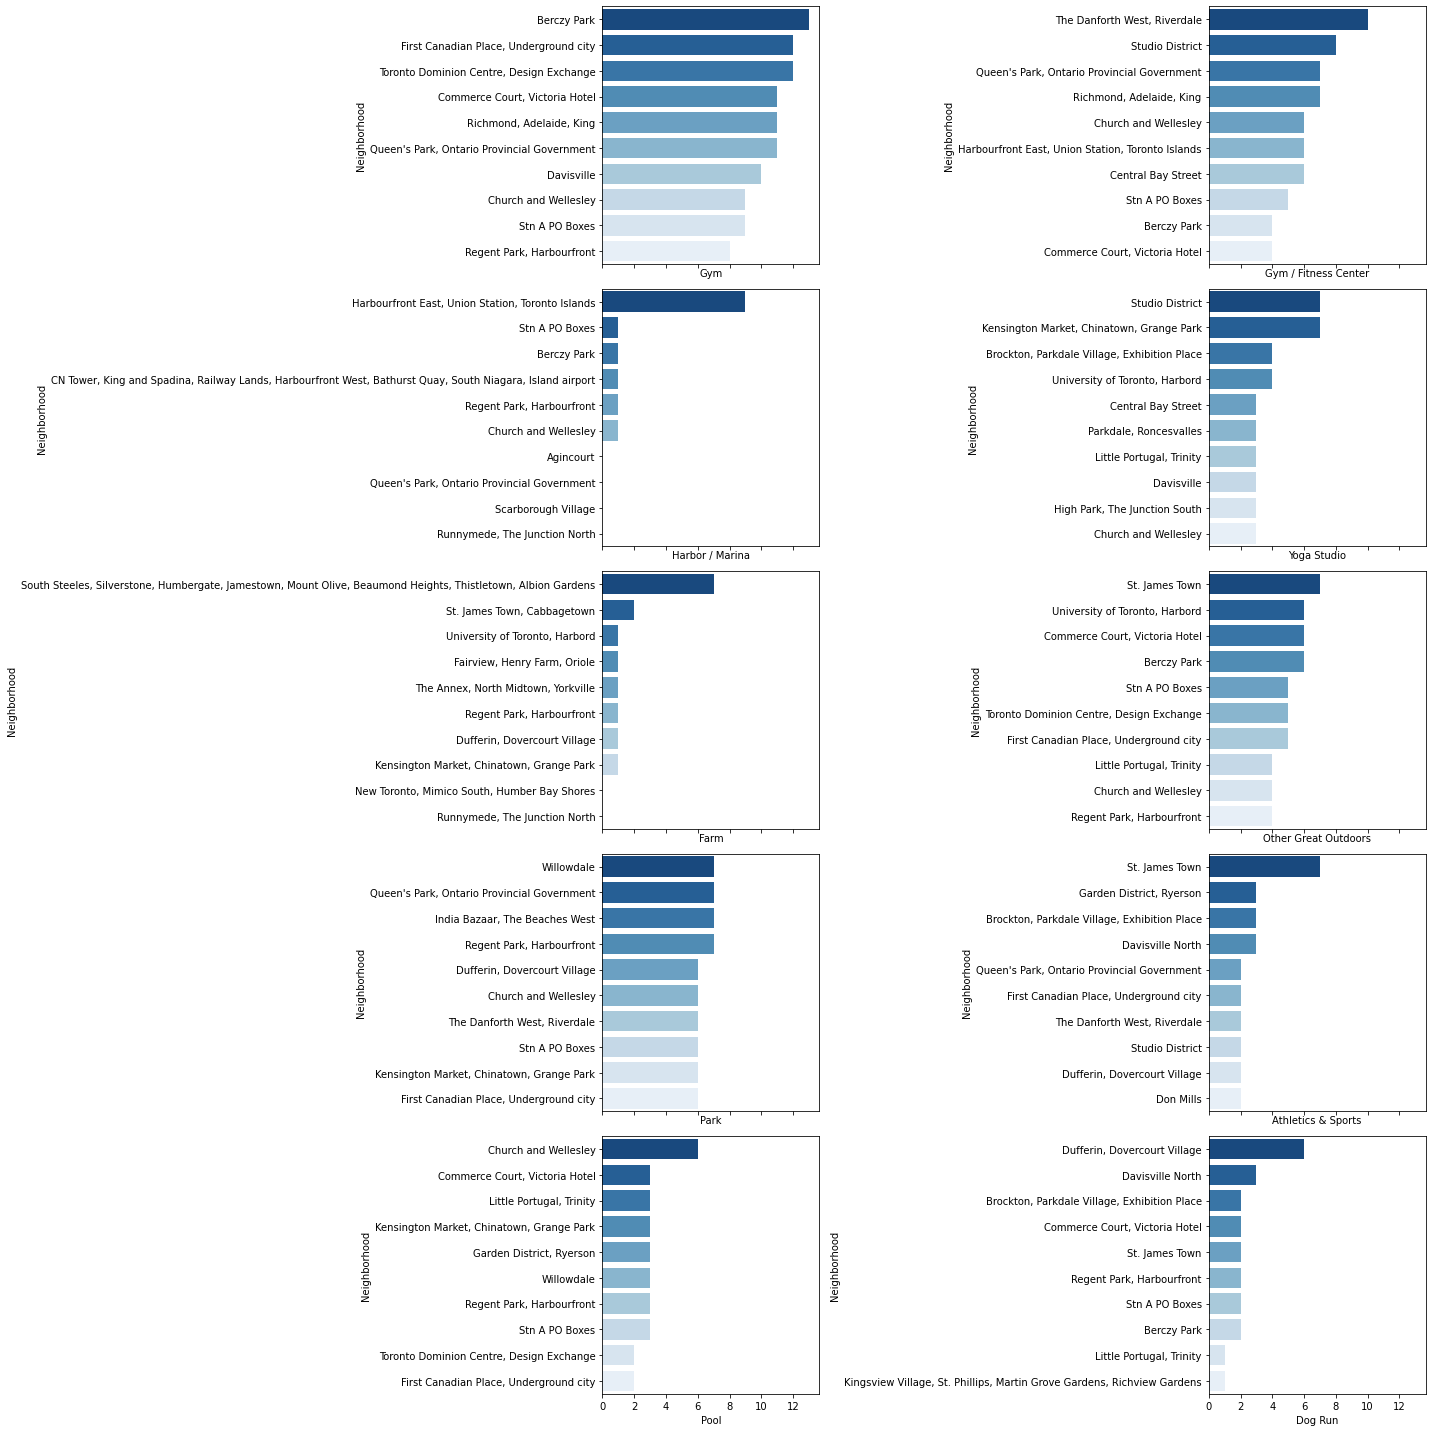

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [46]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Apres Ski Bar,Aquarium,Arcade,Art Gallery,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bike Trail,Boat or Ferry,Botanical Garden,Bowling Alley,Boxing Gym,Bridge,Building,Campground,Cemetery,Climbing Gym,College Gym,College Stadium,Community Center,Curling Ice,Cycle Studio,Distribution Center,Dive Spot,Dog Run,Farm,Field,Flower Shop,Forest,Fountain,Funeral Home,Garden,General Entertainment,Golf Course,Golf Driving Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Historic Site,Hockey Arena,Hot Spring,Hotel Pool,Indoor Play Area,Island,Lake,Lighthouse,Martial Arts Dojo,Medical Center,Monument / Landmark,Mountain,Non-Profit,Other Great Outdoors,Outdoors & Recreation,Park,Pet Service,Pilates Studio,Playground,Plaza,Pool,Public Bathroom,Recreation Center,Residential Building (Apartment / Condo),River,Roof Deck,Scenic Lookout,Sculpture Garden,Skate Park,Skating Rink,Ski Area,Soccer Field,Sports Club,Stables,Stadium,State / Provincial Park,Summer Camp,Surf Spot,Swim School,Tanning Salon,Tennis Court,Track,Trail,Tree,Well,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.000000,0.0,0.0,0.272727,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.428571,0.0,0.0,0.285714,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857
3,Bayview Village,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000


#### Let's confirm the new size

In [47]:
Toronto_grouped.shape

(93, 88)

#### Let's write a function to sort the venues in descending order.

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [49]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [50]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

In [51]:
for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Scenic Lookout,Gym,Skating Rink,Yoga Studio,Forest
1,"Alderwood, Long Branch",Playground,Gym,Gym / Fitness Center,Athletics & Sports,State / Provincial Park
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Playground,Yoga Studio,Community Center,Gym / Fitness Center
3,Bayview Village,Dog Run,Field,Park,Yoga Studio,Hockey Arena
4,"Bedford Park, Lawrence Manor East",Yoga Studio,Gym / Fitness Center,Gym,Playground,Fountain


### Cluster Neighborhoods

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [52]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [53]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

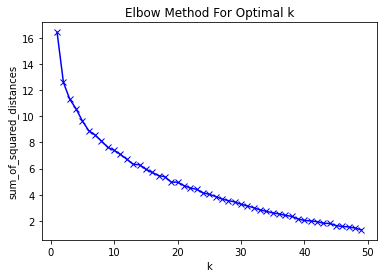

In [54]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [55]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

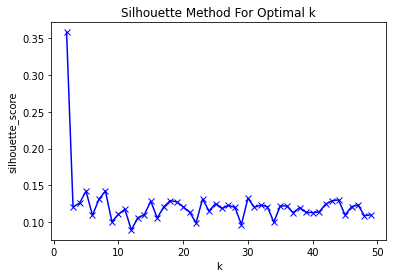

In [56]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [57]:
pd.DataFrame({'Sil':sil,'ksil':K_sil}).head(15)

,Sil,ksil
0,0.357939,2
1,0.120583,3
2,0.125936,4
3,0.142127,5
4,0.109287,6
5,0.131186,7
6,0.142283,8
7,0.100819,9
8,0.110498,10
9,0.117661,11


There is a peak at k = 8.
#### Let's set number of clusters = 8

In [118]:
# set number of clusters
kclusters = 12

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({3: 34, 4: 27, 2: 17, 5: 8, 1: 3, 0: 2, 7: 1, 6: 1})


In [146]:
kmeans.labels_

array([4, 4, 2, 2, 4, 4, 3, 3, 3, 3, 2, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3,
       4, 4, 2, 3, 2, 5, 4, 4, 2, 3, 3, 2, 5, 3, 3, 3, 7, 6, 2, 2, 3, 2,
       3, 4, 3, 3, 4, 3, 4, 2, 4, 2, 2, 2, 3, 1, 3, 4, 1, 4, 4, 4, 2, 0,
       3, 5, 0, 3, 4, 3, 2, 4, 4, 3, 4, 2, 3, 3, 4, 4, 3, 3, 5, 3, 5, 5,
       3, 5, 3, 5, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [119]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [120]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Agincourt,Scenic Lookout,Gym,Skating Rink,Yoga Studio,Forest
1,0,"Alderwood, Long Branch",Playground,Gym,Gym / Fitness Center,Athletics & Sports,State / Provincial Park
2,3,"Bathurst Manor, Wilson Heights, Downsview North",Park,Playground,Yoga Studio,Community Center,Gym / Fitness Center
3,0,Bayview Village,Dog Run,Field,Park,Yoga Studio,Hockey Arena
4,0,"Bedford Park, Lawrence Manor East",Yoga Studio,Gym / Fitness Center,Gym,Playground,Fountain


In [121]:
# merge neighborhoods_venues_sorted with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = neighborhoods_venues_sorted.join(df.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,2,Agincourt,Scenic Lookout,Gym,Skating Rink,Yoga Studio,Forest,M1S,Scarborough,43.794200,-79.262029
1,0,"Alderwood, Long Branch",Playground,Gym,Gym / Fitness Center,Athletics & Sports,State / Provincial Park,M8W,Etobicoke,43.602414,-79.543484
2,3,"Bathurst Manor, Wilson Heights, Downsview North",Park,Playground,Yoga Studio,Community Center,Gym / Fitness Center,M3H,North York,43.754328,-79.442259
3,0,Bayview Village,Dog Run,Field,Park,Yoga Studio,Hockey Arena,M2K,North York,43.786947,-79.385975
4,0,"Bedford Park, Lawrence Manor East",Yoga Studio,Gym / Fitness Center,Gym,Playground,Fountain,M5M,North York,43.733283,-79.419750


Finally, let's visualize the resulting clusters

In [122]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results

In [147]:
required_column_indices = [2,3,8]
required_column = [list(Toronto_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,8]

#### Cluster 0

In [148]:
cluster_0 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
1,"Alderwood, Long Branch",Playground,Gym,Gym / Fitness Center,Athletics & Sports,State / Provincial Park,M8W,Etobicoke,43.602414,-79.543484
3,Bayview Village,Dog Run,Field,Park,Yoga Studio,Hockey Arena,M2K,North York,43.786947,-79.385975
4,"Bedford Park, Lawrence Manor East",Yoga Studio,Gym / Fitness Center,Gym,Playground,Fountain,M5M,North York,43.733283,-79.419750
6,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,General Entertainment,Park,Yoga Studio,M1N,Scarborough,43.692657,-79.264848
7,"Brockton, Parkdale Village, Exhibition Place",Park,Yoga Studio,Gym,Athletics & Sports,Gym / Fitness Center,M6K,West Toronto,43.636847,-79.428191


In [149]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Gym / Fitness Center    12
Park                     8
Gym                      7
Yoga Studio              6
Pool                     3
Athletics & Sports       2
Hockey Arena             1
Other Great Outdoors     1
Garden                   1
Skating Rink             1
River                    1
College Stadium          1
Playground               1
Tree                     1
Dog Run                  1
Harbor / Marina          1
Farm                     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Park                    9
Gym                     5
Athletics & Sports      5
Gym / Fitness Center    5
Yoga Studio             4
Skating Rink            3
Pool                    2
Playground              2
Garden                  2
Other Great Outdoors    2
Dog Run                 2
Cemetery                1
Hockey Arena            1
Harbor / Marina         1
Lake                    1
Recreation Center       1
Boxing Gym              1
Baseball Fi

#### Cluster 1

In [150]:
cluster_1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
27,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Park,Pool,Yoga Studio,Historic Site,Distribution Center,M9C,Etobicoke,43.643515,-79.577201
34,"Guildwood, Morningside, West Hill",Park,Pool,Athletics & Sports,Yoga Studio,Fountain,M1E,Scarborough,43.763573,-79.188711
67,"Runnymede, The Junction North",Park,Athletics & Sports,Yoga Studio,Funeral Home,Dive Spot,M6N,York,43.673185,-79.487262
84,"West Deane Park, Princess Gardens, Martin Grov...",Park,Yoga Studio,Hockey Arena,Distribution Center,Dive Spot,M9B,Etobicoke,43.650943,-79.554724
86,Weston,Park,Yoga Studio,Hockey Arena,Distribution Center,Dive Spot,M9N,York,43.706876,-79.518188


In [151]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Park    8
Pool    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yoga Studio           4
Pool                  2
Athletics & Sports    1
Park                  1
Trail                 1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York     3
York           2
Etobicoke      2
Scarborough    2
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 2

In [152]:
cluster_2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,Agincourt,Scenic Lookout,Gym,Skating Rink,Yoga Studio,Forest,M1S,Scarborough,43.794200,-79.262029
5,Berczy Park,Gym,Other Great Outdoors,Gym / Fitness Center,Park,Sculpture Garden,M5E,Downtown Toronto,43.644771,-79.373306
11,Canada Post Gateway Processing Centre,Gym,Gym / Fitness Center,Martial Arts Dojo,Playground,Yoga Studio,M7R,Mississauga,43.636966,-79.615819
18,"Commerce Court, Victoria Hotel",Gym,Other Great Outdoors,Gym / Fitness Center,Park,Pool,M5L,Downtown Toronto,43.648198,-79.379817
19,Davisville,Gym,Park,Yoga Studio,Other Great Outdoors,Playground,M4S,Central Toronto,43.704324,-79.388790


In [153]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Gym                   15
Athletics & Sports     1
Pool                   1
Scenic Lookout         1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Park                    3
Other Great Outdoors    3
Gym / Fitness Center    3
Martial Arts Dojo       2
Gym                     2
Athletics & Sports      1
Dog Run                 1
Yoga Studio             1
Playground              1
Baseball Field          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Downtown Toronto    6
North York          4
Scarborough         4
Central Toronto     2
Mississauga         1
Etobicoke           1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 3

In [154]:
cluster_3 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Playground,Yoga Studio,Community Center,Gym / Fitness Center,M3H,North York,43.754328,-79.442259
10,Caledonia-Fairbanks,Park,Pool,Playground,Cemetery,Yoga Studio,M6E,York,43.689026,-79.453512
24,Downsview,Park,Soccer Field,Playground,Gym / Fitness Center,Athletics & Sports,M3K,North York,43.737473,-79.464763
24,Downsview,Park,Soccer Field,Playground,Gym / Fitness Center,Athletics & Sports,M3L,North York,43.739015,-79.506944
24,Downsview,Park,Soccer Field,Playground,Gym / Fitness Center,Athletics & Sports,M3M,North York,43.728496,-79.495697


In [155]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Park          15
Playground     3
Trail          1
Cemetery       1
Pool           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Playground              10
Soccer Field             5
Hockey Arena             1
Garden                   1
Pool                     1
Trail                    1
Gym Pool                 1
Gym / Fitness Center     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York          6
Scarborough         4
Central Toronto     3
Etobicoke           2
East Toronto        2
York                2
Downtown Toronto    1
East York           1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 4

In [156]:
cluster_4 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
39,"Humberlea, Emery",Baseball Field,Yoga Studio,Funeral Home,Distribution Center,Dive Spot,M9M,North York,43.724766,-79.532242


In [157]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Baseball Field    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yoga Studio    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York    1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 5

In [164]:
cluster_5 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude


In [165]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Series([], Name: 1st Most Common Venue, dtype: int64)
---------------------------------------------
Series([], Name: 2nd Most Common Venue, dtype: int64)
---------------------------------------------
Series([], Name: Borough, dtype: int64)
---------------------------------------------
